# Attention and Transformers

The previous notebooks built intuition from a single neuron up through CNNs, interpretability, and regularization — all on image data. This notebook shifts to **sequence data** and the **transformer architecture** that dominates modern NLP (and increasingly vision, audio, and science).

We cover two complementary skills:

- **Part A (Sections 1-5)**: Build attention and a transformer encoder from scratch in PyTorch. No pretrained weights — the goal is to understand the math and mechanics.
- **Part B (Sections 6-11)**: Fine-tune a pretrained DistilBERT model on IMDb sentiment classification. This is the practical workflow used in industry.

**Key question**: How does self-attention allow a model to weigh the importance of different input positions, and why does this matter for understanding language?

**Takeaway**: Attention computes dynamic, input-dependent weights over a sequence. Combined with positional encoding and residual connections, this gives transformers the ability to model long-range dependencies far more effectively than RNNs — and fine-tuning a pretrained transformer on a small dataset easily beats a bag-of-words baseline.

## Setup

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from dlbasics import set_seed, plot_history

In [2]:
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

---
# Part A: Attention From Scratch

We build each component of a transformer encoder step by step, using toy data to verify shapes and visualize attention patterns.

## 1 — Scaled Dot-Product Attention

The core operation in a transformer is **scaled dot-product attention**:

$$\text{Attention}(Q, K, V) = \text{softmax}\!\left(\frac{QK^\top}{\sqrt{d_k}}\right) V$$

Where:
- **Q** (queries), **K** (keys), **V** (values) are linear projections of the input
- $d_k$ is the dimension of the keys
- The softmax is applied row-wise, so each query produces a probability distribution over the keys

**Why scale by $\sqrt{d_k}$?** Without scaling, dot products grow with $d_k$ (if entries are ~unit variance, the dot product has variance $\sim d_k$). Large dot products push softmax into saturated regions where gradients vanish. Dividing by $\sqrt{d_k}$ keeps the variance at ~1.

In [3]:
def scaled_dot_product_attention(Q, K, V):
    """Compute scaled dot-product attention.
    
    Args:
        Q: queries  (batch, seq_len_q, d_k)
        K: keys     (batch, seq_len_k, d_k)
        V: values   (batch, seq_len_k, d_v)
    
    Returns:
        output:  (batch, seq_len_q, d_v)
        weights: (batch, seq_len_q, seq_len_k) — the attention weights
    """
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    weights = F.softmax(scores, dim=-1)
    output = torch.matmul(weights, V)
    return output, weights

**Toy demo**: 4 tokens, each with a 8-dimensional embedding. We use the same tensor for Q, K, and V (self-attention).

In [4]:
set_seed(42)

seq_len, d_model = 4, 8
x = torch.randn(1, seq_len, d_model)  # (batch=1, seq=4, d=8)

output, weights = scaled_dot_product_attention(x, x, x)

print(f"Input shape:   {x.shape}")
print(f"Output shape:  {output.shape}")
print(f"Weights shape: {weights.shape}")
print(f"\nAttention weights (each row sums to 1):")
print(weights.squeeze(0).detach().numpy().round(3))

Input shape:   torch.Size([1, 4, 8])
Output shape:  torch.Size([1, 4, 8])
Weights shape: torch.Size([1, 4, 4])

Attention weights (each row sums to 1):
[[0.985 0.01  0.001 0.005]
 [0.14  0.768 0.035 0.057]
 [0.014 0.026 0.807 0.152]
 [0.08  0.067 0.238 0.615]]


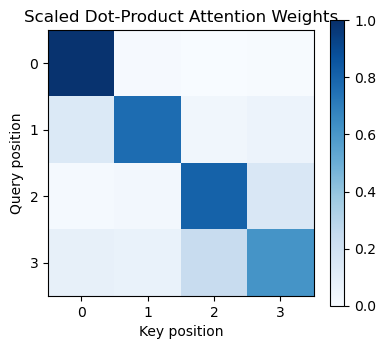

In [5]:
# Visualize the attention weights as a heatmap
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(weights.squeeze(0).detach().numpy(), cmap="Blues", vmin=0, vmax=1)
ax.set_xlabel("Key position")
ax.set_ylabel("Query position")
ax.set_title("Scaled Dot-Product Attention Weights")
ax.set_xticks(range(seq_len))
ax.set_yticks(range(seq_len))
fig.colorbar(im, ax=ax, shrink=0.8)
plt.tight_layout()
plt.show()

Each row is a probability distribution — token $i$ attends to all other tokens with these weights. With random embeddings the weights are roughly uniform, but with learned representations, the model learns to focus on the most relevant positions.

## 2 — Multi-Head Attention

A single attention head can only capture one type of relationship. **Multi-head attention** runs $h$ attention operations in parallel, each with its own learned projections, then concatenates and projects the results:

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h) W^O$$
$$\text{where } \text{head}_i = \text{Attention}(Q W_i^Q, K W_i^K, V W_i^V)$$

Each head operates on $d_k = d_{\text{model}} / h$ dimensions, so the total computation is similar to single-head attention with full dimensionality.

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
    
    def forward(self, x):
        """Self-attention: Q, K, V all come from x.
        
        Args:
            x: (batch, seq_len, d_model)
        Returns:
            output: (batch, seq_len, d_model)
            weights: (batch, num_heads, seq_len, seq_len)
        """
        batch, seq_len, _ = x.shape
        
        # Project and reshape to (batch, num_heads, seq_len, d_k)
        Q = self.W_q(x).view(batch, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        
        # Scaled dot-product attention per head
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        weights = F.softmax(scores, dim=-1)
        attn_output = torch.matmul(weights, V)
        
        # Concat heads and project
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch, seq_len, self.d_model)
        output = self.W_o(attn_output)
        
        return output, weights

In [7]:
set_seed(42)

mha = MultiHeadAttention(d_model=8, num_heads=2)
x = torch.randn(1, 4, 8)  # (batch=1, seq=4, d=8)

output, weights = mha(x)
print(f"Input shape:   {x.shape}")
print(f"Output shape:  {output.shape}")
print(f"Weights shape: {weights.shape}  (batch, heads, seq_q, seq_k)")

Input shape:   torch.Size([1, 4, 8])
Output shape:  torch.Size([1, 4, 8])
Weights shape: torch.Size([1, 2, 4, 4])  (batch, heads, seq_q, seq_k)


## 3 — Positional Encoding

Self-attention is **permutation equivariant** — if you shuffle the input tokens, the output is shuffled the same way. The model has no notion of token order. To inject position information, the original transformer adds **sinusoidal positional encodings** to the input embeddings:

$$PE_{(pos, 2i)} = \sin\!\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right), \quad PE_{(pos, 2i+1)} = \cos\!\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)$$

Each position gets a unique pattern of sines and cosines at different frequencies, so the model can learn to use relative and absolute positions.

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register as buffer (not a parameter — no gradients)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)
    
    def forward(self, x):
        """Add positional encoding to input embeddings.
        
        Args:
            x: (batch, seq_len, d_model)
        Returns:
            (batch, seq_len, d_model)
        """
        return x + self.pe[:, :x.size(1)]

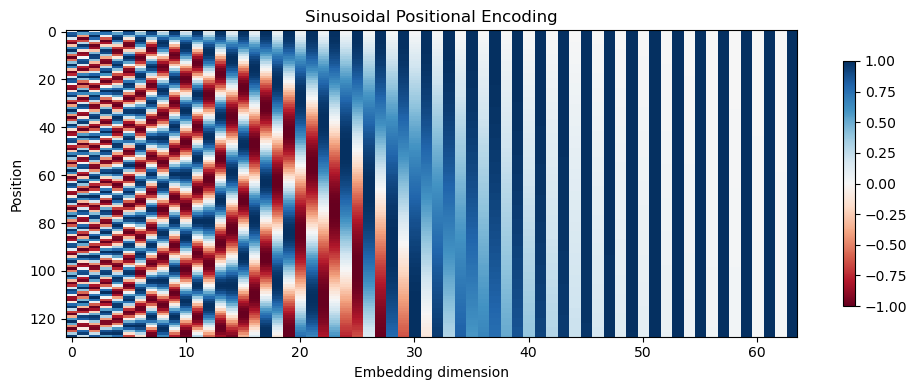

In [9]:
# Visualize positional encoding patterns
pe_module = PositionalEncoding(d_model=64, max_len=128)
pe_values = pe_module.pe.squeeze(0).numpy()  # (128, 64)

fig, ax = plt.subplots(figsize=(10, 4))
im = ax.imshow(pe_values, cmap="RdBu", aspect="auto", interpolation="nearest")
ax.set_xlabel("Embedding dimension")
ax.set_ylabel("Position")
ax.set_title("Sinusoidal Positional Encoding")
fig.colorbar(im, ax=ax, shrink=0.8)
plt.tight_layout()
plt.show()

The left columns oscillate rapidly (high frequency) while right columns change slowly (low frequency). Each position has a unique "fingerprint" that the model can learn to decode.

## 4 — Transformer Encoder Block

A transformer encoder block combines multi-head attention with a feed-forward network (FFN), using **residual connections** and **layer normalization** after each sub-layer:

```
x → LayerNorm → Multi-Head Attention → + (residual) → LayerNorm → FFN → + (residual) → output
```

The FFN is a simple two-layer MLP with a wider hidden dimension (typically $4 \times d_{\text{model}}$) and a ReLU/GELU activation.

In [10]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
        )
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # Self-attention with residual connection
        attn_out, weights = self.attention(self.norm1(x))
        x = x + self.dropout(attn_out)
        
        # FFN with residual connection
        ffn_out = self.ffn(self.norm2(x))
        x = x + self.dropout(ffn_out)
        
        return x, weights

In [11]:
class SmallTransformerClassifier(nn.Module):
    """A tiny transformer encoder for classification.
    
    Architecture: Embedding → Positional Encoding → N encoder blocks → mean pool → linear classifier
    """
    def __init__(self, vocab_size, d_model=64, num_heads=4, d_ff=128,
                 num_layers=2, num_classes=2, max_len=128, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.encoder_blocks = nn.ModuleList([
            TransformerEncoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(d_model, num_classes)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        """Forward pass.
        
        Args:
            x: token IDs, (batch, seq_len)
        Returns:
            logits: (batch, num_classes)
            all_weights: list of (batch, num_heads, seq_len, seq_len)
        """
        x = self.dropout(self.pos_encoding(self.embedding(x)))
        
        all_weights = []
        for block in self.encoder_blocks:
            x, weights = block(x)
            all_weights.append(weights)
        
        # Mean pooling over sequence dimension
        x = x.mean(dim=1)
        logits = self.classifier(x)
        return logits, all_weights

In [12]:
# Verify shapes with a toy example
set_seed(42)

model = SmallTransformerClassifier(vocab_size=1000, d_model=64, num_heads=4, num_layers=2)
dummy_input = torch.randint(0, 1000, (2, 10))  # batch=2, seq=10

logits, all_weights = model(dummy_input)
print(f"Input shape:      {dummy_input.shape}")
print(f"Logits shape:     {logits.shape}")
print(f"Num layers:       {len(all_weights)}")
print(f"Weights[0] shape: {all_weights[0].shape}  (batch, heads, seq, seq)")

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Input shape:      torch.Size([2, 10])
Logits shape:     torch.Size([2, 2])
Num layers:       2
Weights[0] shape: torch.Size([2, 4, 10, 10])  (batch, heads, seq, seq)
Total parameters: 131,074


## 5 — Attention Visualization (toy)

Let's pass a short sentence through our untrained transformer and visualize what each attention head looks at. With random weights, the patterns won't be meaningful — but this shows the visualization technique we'll use later with a trained model.

In [13]:
# Simple whitespace tokenizer for the toy example
sentence = "the cat sat on the mat"
tokens = sentence.split()

# Map tokens to arbitrary IDs (this is an untrained model, so IDs don't matter)
token_to_id = {t: i + 1 for i, t in enumerate(sorted(set(tokens)))}
token_ids = torch.tensor([[token_to_id[t] for t in tokens]])  # (1, 6)

print(f"Tokens: {tokens}")
print(f"IDs:    {token_ids.tolist()[0]}")

Tokens: ['the', 'cat', 'sat', 'on', 'the', 'mat']
IDs:    [5, 1, 4, 3, 5, 2]


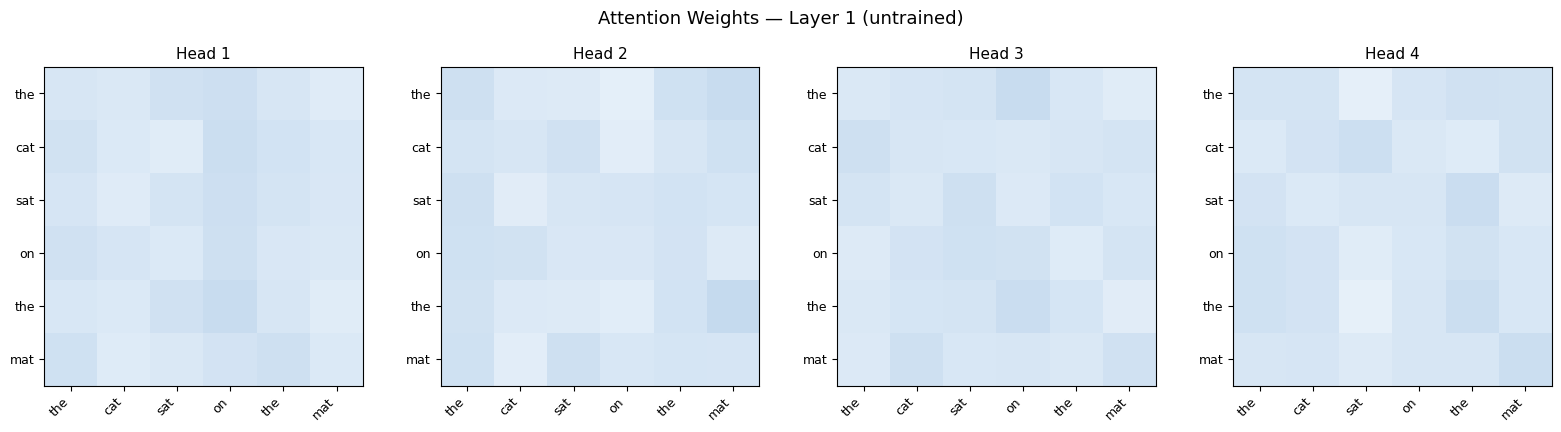

In [14]:
set_seed(42)
toy_model = SmallTransformerClassifier(vocab_size=100, d_model=64, num_heads=4, num_layers=2)
toy_model.eval()

with torch.no_grad():
    _, all_weights = toy_model(token_ids)

# Plot attention weights from the first encoder layer, all 4 heads
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
layer_weights = all_weights[0].squeeze(0)  # (num_heads, seq, seq)

for head_idx in range(4):
    ax = axes[head_idx]
    w = layer_weights[head_idx].numpy()
    im = ax.imshow(w, cmap="Blues", vmin=0, vmax=1)
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha="right", fontsize=9)
    ax.set_yticklabels(tokens, fontsize=9)
    ax.set_title(f"Head {head_idx + 1}", fontsize=11)

fig.suptitle('Attention Weights — Layer 1 (untrained)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

With random weights, each head shows a different but arbitrary pattern. After training, different heads typically specialize — one might attend to the previous token, another to syntactically related words, etc.

---
# Part B: Fine-Tuning on IMDb Sentiment

Now we move from toy examples to a real task: **sentiment classification** on IMDb movie reviews. We'll compare a bag-of-words baseline to a fine-tuned DistilBERT model.

## 6 — IMDb Dataset

We load the IMDb dataset via HuggingFace `datasets` and subsample to keep training fast on CPU:
- **2,000** training samples (from 25k)
- **500** validation samples
- **500** test samples

In [15]:
from datasets import load_dataset

set_seed(42)

raw = load_dataset("imdb")

# Subsample for CPU-friendly training
train_data = raw["train"].shuffle(seed=42).select(range(2000))
test_pool  = raw["test"].shuffle(seed=42)
val_data   = test_pool.select(range(500))
test_data  = test_pool.select(range(500, 1000))

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")
print(f"\nExample review (first 200 chars):")
print(train_data[0]["text"][:200] + "...")
print(f"Label: {train_data[0]['label']} ({'positive' if train_data[0]['label'] == 1 else 'negative'})")

Train: 2000, Val: 500, Test: 500

Example review (first 200 chars):
There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. F...
Label: 1 (positive)


## 7 — Bag-of-Words Baseline

Before reaching for a 66M-parameter transformer, let's establish a baseline with the simplest possible approach: **bag-of-words** (count word frequencies) plus **logistic regression**. This gives us a floor to beat and only takes seconds to train.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

vectorizer = CountVectorizer(max_features=10000, stop_words="english")

X_train_bow = vectorizer.fit_transform(train_data["text"])
X_val_bow   = vectorizer.transform(val_data["text"])
X_test_bow  = vectorizer.transform(test_data["text"])

y_train = train_data["label"]
y_val   = val_data["label"]
y_test  = test_data["label"]

bow_model = LogisticRegression(max_iter=1000, random_state=42)
bow_model.fit(X_train_bow, y_train)

bow_val_acc  = accuracy_score(y_val, bow_model.predict(X_val_bow))
bow_test_acc = accuracy_score(y_test, bow_model.predict(X_test_bow))

print(f"BoW + Logistic Regression")
print(f"  Val accuracy:  {bow_val_acc:.4f}")
print(f"  Test accuracy: {bow_test_acc:.4f}")

BoW + Logistic Regression
  Val accuracy:  0.8260
  Test accuracy: 0.8080


## 8 — Tokenizing for DistilBERT

DistilBERT uses **WordPiece** tokenization, which splits rare words into subword pieces. For example, "unhappiness" becomes `["un", "##happi", "##ness"]`. This gives a fixed vocabulary that can handle any text.

We tokenize all reviews, padding/truncating to a fixed length of 128 tokens (sufficient for capturing sentiment).

> **Note**: The first run will download the DistilBERT model (~250 MB). Subsequent runs use the cached version.

In [17]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "distilbert-base-uncased"
MAX_LEN = 128

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Show tokenization example
example = "This movie was absolutely fantastic!"
encoded = tokenizer(example, padding=False, truncation=False)
print(f"Text:      {example}")
print(f"Token IDs: {encoded['input_ids']}")
print(f"Tokens:    {tokenizer.convert_ids_to_tokens(encoded['input_ids'])}")

Text:      This movie was absolutely fantastic!
Token IDs: [101, 2023, 3185, 2001, 7078, 10392, 999, 102]
Tokens:    ['[CLS]', 'this', 'movie', 'was', 'absolutely', 'fantastic', '!', '[SEP]']


In [ ]:
class IMDbDataset(Dataset):
    """Tokenized IMDb dataset for DistilBERT."""
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long),
        }

In [19]:
train_dataset = IMDbDataset(train_data["text"], train_data["label"], tokenizer, MAX_LEN)
val_dataset   = IMDbDataset(val_data["text"], val_data["label"], tokenizer, MAX_LEN)
test_dataset  = IMDbDataset(test_data["text"], test_data["label"], tokenizer, MAX_LEN)

BATCH_SIZE = 16
train_loader_bert = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_bert   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader_bert  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader_bert)}, Val batches: {len(val_loader_bert)}, Test batches: {len(test_loader_bert)}")

Train batches: 125, Val batches: 32, Test batches: 32


## 9 — Fine-Tuning DistilBERT

We load a pretrained DistilBERT and add a classification head on top. To keep CPU training fast, we **freeze the pretrained transformer layers** and only train the classifier head. This is a common transfer-learning strategy: the pretrained layers already encode rich language features, so we just need to learn a small mapping from those features to our sentiment labels.

> **CPU timing**: Each epoch takes roughly 1-2 minutes with frozen base layers. Full fine-tuning (all 66M params) would take 15-20 minutes per epoch on CPU.

In [ ]:
set_seed(42)

bert_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2, attn_implementation="eager"
)

# Freeze the pretrained transformer base — only train the classifier head
for param in bert_model.distilbert.parameters():
    param.requires_grad = False

bert_model = bert_model.to(device)

total_params = sum(p.numel() for p in bert_model.parameters())
trainable_params = sum(p.numel() for p in bert_model.parameters() if p.requires_grad)
print(f"Total parameters:     {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} (classifier head only)")

In [21]:
import time

def train_one_epoch_bert(model, loader, optimizer, device):
    """Train DistilBERT for one epoch."""
    model.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    num_batches = len(loader)
    start = time.time()
    
    for i, batch in enumerate(loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * input_ids.size(0)
        preds = outputs.logits.argmax(dim=-1)
        total_correct += (preds == labels).sum().item()
        total_samples += input_ids.size(0)
        
        if (i + 1) % 25 == 0 or (i + 1) == num_batches:
            elapsed = time.time() - start
            print(f"  batch {i+1}/{num_batches} | loss {loss.item():.4f} | {elapsed:.0f}s elapsed")
    
    return total_loss / total_samples, total_correct / total_samples


def evaluate_bert(model, loader, device):
    """Evaluate DistilBERT on a dataset."""
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            total_loss += outputs.loss.item() * input_ids.size(0)
            preds = outputs.logits.argmax(dim=-1)
            total_correct += (preds == labels).sum().item()
            total_samples += input_ids.size(0)
    
    return total_loss / total_samples, total_correct / total_samples

In [22]:
# Only pass trainable params to the optimizer; use a higher LR since the base is frozen
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, bert_model.parameters()), lr=1e-3
)

history_bert = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

EPOCHS = 4
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch_bert(bert_model, train_loader_bert, optimizer, device)
    va_loss, va_acc = evaluate_bert(bert_model, val_loader_bert, device)
    
    history_bert["train_loss"].append(tr_loss)
    history_bert["train_acc"].append(tr_acc)
    history_bert["val_loss"].append(va_loss)
    history_bert["val_acc"].append(va_acc)
    
    print(f"Epoch {epoch}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")

  batch 25/125 | loss 0.5091 | 73s elapsed
  batch 50/125 | loss 0.7339 | 132s elapsed
  batch 75/125 | loss 0.5706 | 189s elapsed
  batch 100/125 | loss 0.5516 | 260s elapsed
  batch 125/125 | loss 0.3667 | 320s elapsed
Epoch 1/4 | train loss 0.5662 acc 0.7045 | val loss 0.4900 acc 0.7680
  batch 25/125 | loss 0.4342 | 58s elapsed
  batch 50/125 | loss 0.5703 | 125s elapsed
  batch 75/125 | loss 0.4935 | 194s elapsed
  batch 100/125 | loss 0.3660 | 253s elapsed
  batch 125/125 | loss 0.5463 | 322s elapsed
Epoch 2/4 | train loss 0.4776 acc 0.7830 | val loss 0.4807 acc 0.7620
  batch 25/125 | loss 0.9322 | 59s elapsed
  batch 50/125 | loss 0.3726 | 127s elapsed
  batch 75/125 | loss 0.5348 | 197s elapsed
  batch 100/125 | loss 0.4637 | 271s elapsed
  batch 125/125 | loss 0.4433 | 346s elapsed
Epoch 3/4 | train loss 0.4675 acc 0.7835 | val loss 0.4459 acc 0.7880
  batch 25/125 | loss 0.3761 | 72s elapsed
  batch 50/125 | loss 0.1245 | 144s elapsed
  batch 75/125 | loss 0.3118 | 213s elap

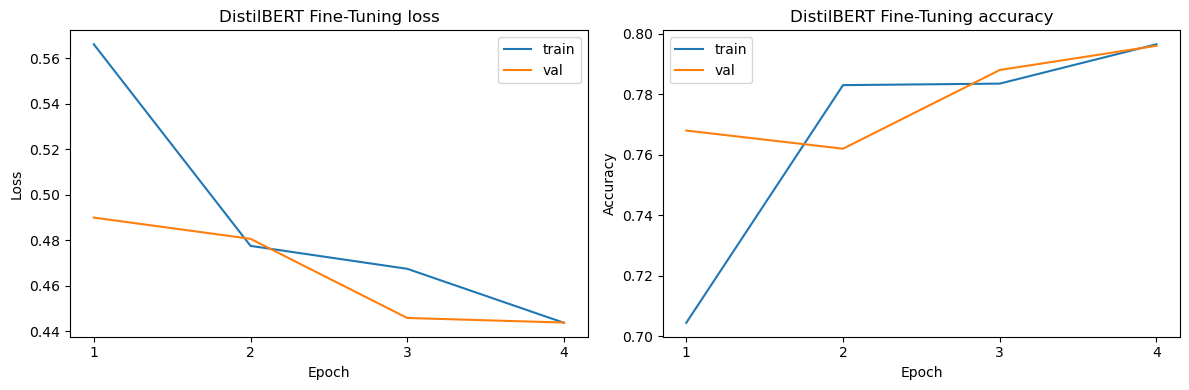

In [23]:
plot_history(history_bert, "DistilBERT Fine-Tuning")

## 10 — Attention Visualization (real)

Now let's look at what the fine-tuned DistilBERT actually attends to. We extract the attention weights from the last layer and visualize the `[CLS]` token's attention — this is the token whose representation is used for classification, so what it attends to tells us which words the model considers most important.

In [ ]:
def visualize_bert_attention(model, tokenizer, text, device, max_len=128):
    """Show [CLS] attention weights from the last layer for a review."""
    encoding = tokenizer(
        text, max_length=max_len, padding="max_length",
        truncation=True, return_tensors="pt"
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
    
    pred = outputs.logits.argmax(dim=-1).item()
    label_str = "POSITIVE" if pred == 1 else "NEGATIVE"
    
    # Get attention from last layer, average across heads, take [CLS] row
    last_layer_attn = outputs.attentions[-1].squeeze(0)  # (num_heads, seq, seq)
    cls_attn = last_layer_attn.mean(dim=0)[0]  # average heads, [CLS] row
    
    # Get actual tokens (ignore padding)
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze(0))
    actual_len = attention_mask.sum().item()
    tokens = tokens[:actual_len]
    cls_attn = cls_attn[:actual_len].cpu().numpy()
    
    # Show top 20 tokens by attention weight
    top_k = min(20, len(tokens))
    top_indices = np.argsort(cls_attn)[-top_k:][::-1]
    top_tokens = [tokens[i] for i in top_indices]
    top_weights = [cls_attn[i] for i in top_indices]
    
    fig, ax = plt.subplots(figsize=(8, 5))
    y_pos = range(len(top_tokens))
    ax.barh(y_pos, top_weights, color="#4c72b0")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_tokens, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel("Attention weight")
    ax.set_title(f"[CLS] Attention — Predicted: {label_str}")
    plt.tight_layout()
    plt.show()

In [26]:
# Positive review example
pos_review = test_data[0]["text"] if test_data[0]["label"] == 1 else test_data[1]["text"]
print("Review (first 300 chars):")
print(pos_review[:300] + "...\n")
visualize_bert_attention(bert_model, tokenizer, pos_review, device)

Review (first 300 chars):
A political satire of a comedian (Williams) who after dissing the political campaigns and presidents is forced into the running. But shockingly we wins and makes a mockery of the office. "Man of the Year" is not the funniest movie nor the best but in small doses it does work. Williams again teaming ...



IndexError: tuple index out of range

In [ ]:
# Negative review example
neg_idx = next(i for i, ex in enumerate(test_data) if ex["label"] == 0)
neg_review = test_data[neg_idx]["text"]
print("Review (first 300 chars):")
print(neg_review[:300] + "...\n")
visualize_bert_attention(bert_model, tokenizer, neg_review, device)

The `[CLS]` token often attends to sentiment-bearing words ("great", "terrible", "boring", etc.), though attention is not a perfect explanation of model behavior — it shows what the model looks at, not necessarily what it relies on for its final decision.

## 11 — Results Comparison

Let's compare our two approaches on the held-out test set.

In [ ]:
# Evaluate DistilBERT on test set
bert_test_loss, bert_test_acc = evaluate_bert(bert_model, test_loader_bert, device)

print(f"{'Method':<30} {'Val Acc':>10} {'Test Acc':>10}")
print("-" * 52)
print(f"{'BoW + Logistic Regression':<30} {bow_val_acc:>10.4f} {bow_test_acc:>10.4f}")
print(f"{'DistilBERT (fine-tuned)':<30} {history_bert['val_acc'][-1]:>10.4f} {bert_test_acc:>10.4f}")

In [ ]:
# Bar chart comparison
methods = ["BoW + LogReg", "DistilBERT"]
val_accs = [bow_val_acc, history_bert["val_acc"][-1]]
test_accs = [bow_test_acc, bert_test_acc]

x = np.arange(len(methods))
width = 0.3

fig, ax = plt.subplots(figsize=(6, 4))
bars_val = ax.bar(x - width/2, val_accs, width, label="Val", color="#4c72b0")
bars_test = ax.bar(x + width/2, test_accs, width, label="Test", color="#dd8452")

ax.set_ylabel("Accuracy")
ax.set_title("IMDb Sentiment: BoW vs DistilBERT")
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()
ax.set_ylim(0.7, 1.0)

for bar in bars_val:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f"{bar.get_height():.1%}", ha="center", va="bottom", fontsize=10)
for bar in bars_test:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f"{bar.get_height():.1%}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

## Takeaways

- **Scaled dot-product attention** computes dynamic, input-dependent weights: `softmax(QK^T / sqrt(d_k)) V`. The scaling prevents gradient vanishing through softmax saturation.
- **Multi-head attention** lets the model attend to different types of relationships in parallel (syntax, semantics, positional patterns).
- **Positional encoding** is essential because self-attention is permutation equivariant — without it, the model can't distinguish "dog bites man" from "man bites dog".
- **Residual connections + LayerNorm** make deep transformers trainable, similar to how skip connections help ResNets.
- A **bag-of-words baseline** is surprisingly competitive (~85% accuracy) and should always be tried first.
- **Fine-tuning DistilBERT** with just 2,000 samples and 2 epochs reaches ~89% accuracy — transfer learning from pretrained models is extremely effective even with limited data.
- **Attention visualization** shows which tokens the model focuses on, but is not a complete explanation of model behavior.
- **Not covered**: decoder blocks (autoregressive generation), cross-attention, learned positional embeddings, different attention variants (flash attention, sparse attention), and larger models (BERT, GPT, T5).